# Compare genres of input and output books

In [116]:
import gensim
from gensim.models import Doc2Vec, KeyedVectors
import logging
import time
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import requests
import matplotlib.pyplot as plt
import gensim.downloader as api # Downloading the Google pretrained Word2Vec Model

In [117]:
import numpy as np
import requests
import random
from tqdm.notebook import tqdm
tqdm.pandas()

In [118]:
import os
import json
import glob
import re
import sys
import collections
from nltk import flatten
import dask
from dask import delayed,compute
import dask.dataframe as dd
from dask.multiprocessing import get
import logging
from sklearn.metrics.pairwise import cosine_similarity

In [70]:
from sklearn.metrics import multilabel_confusion_matrix
import ast
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import precision_score, recall_score, f1_score,classification_report
from itertools import repeat

In [71]:
#read dataset
books_df = pd.read_csv('unique_books.csv')
#drop na (subset-genre)
books_df = books_df.dropna(subset=['genres'])
#remove quotes from around genre list
books_df['genres'] = books_df.loc[books_df['genres']!=np.nan, 'genres'].progress_apply(lambda x: ast.literal_eval(x))

  0%|          | 0/4319 [00:00<?, ?it/s]

In [85]:
#create list of genres
genres_list = []
for i in books_df['genres']:
    genres_list.extend(i)
#create unique list of genres
unique_genres_list = sorted(list(set(genres_list)))
unique_genres_df = pd.DataFrame.from_dict({'genres': sorted(unique_genres_list)})
num_genres = len(unique_genres_list)
num_genres

423

## Step 1: 
Original books genres -> matrix

In [119]:
#Read in recommendations as df
paragraph_recs_df = pd.read_csv('paragraph_vec_recs_small_dataset.csv')

In [120]:
orig_book_indices = list(books_df.index)

In [121]:
num_orig_books = len(orig_book_indices)
num_orig_books

4319

In [123]:
recommended_books_df = paragraph_recs_df
recommended_books_df.head()

,Unnamed: 0,book_id,isbn,book_authors,book_title,genres,similarity_scores,orig_book_idx
0,1,26,307277674,['Dan Brown'],The Da Vinci Code,"['Fiction', 'Mystery', 'Thriller']",0.000235,0
1,3,33,739326228,['Arthur Golden'],Memoirs of a Geisha,"['Fiction', 'Historical', 'Historical Fiction'...",0.000083,0
2,7,388,689840926,['Gary Paulsen'],Hatchet,"['Young Adult', 'Fiction', 'Adventure', 'Class...",0.000038,0
3,29,778,451527887,"['Alain Erlande-Brandenburg', 'Caroline Rose',...",Notre-Dame de Paris,"['Classics', 'Nonfiction', 'History', 'Cultura...",0.000025,0
4,24,325,552135399,['John Irving'],A Prayer for Owen Meany,"['Fiction', 'Classics', 'Literature', 'Contemp...",0.000022,0


In [124]:
recommended_books_df.shape

(43300, 8)

### Remove recommendations for books that are no longer in the original books dataset

In [125]:
missing_orig_books_indices_list = []
for idx in list(set(recommended_books_df['orig_book_idx'])):
    if idx not in orig_book_indices:
        missing_orig_books_indices_list.append(idx)

In [126]:
missing_orig_books_indices_list

[779, 3236, 4193, 4245, 4323, 4324, 4325, 4326, 4327, 4328, 4329]

In [127]:
recommended_books_df_rows_to_remove = []
for row_num in range(recommended_books_df.shape[0]):
    if recommended_books_df['orig_book_idx'][row_num] in (missing_orig_books_indices_list):
        recommended_books_df_rows_to_remove.append(row_num)

In [128]:
recommended_books_df_rows_to_remove

[7790,
 7791,
 7792,
 7793,
 7794,
 7795,
 7796,
 7797,
 7798,
 7799,
 32360,
 32361,
 32362,
 32363,
 32364,
 32365,
 32366,
 32367,
 32368,
 32369,
 41930,
 41931,
 41932,
 41933,
 41934,
 41935,
 41936,
 41937,
 41938,
 41939,
 42450,
 42451,
 42452,
 42453,
 42454,
 42455,
 42456,
 42457,
 42458,
 42459,
 43230,
 43231,
 43232,
 43233,
 43234,
 43235,
 43236,
 43237,
 43238,
 43239,
 43240,
 43241,
 43242,
 43243,
 43244,
 43245,
 43246,
 43247,
 43248,
 43249,
 43250,
 43251,
 43252,
 43253,
 43254,
 43255,
 43256,
 43257,
 43258,
 43259,
 43260,
 43261,
 43262,
 43263,
 43264,
 43265,
 43266,
 43267,
 43268,
 43269,
 43270,
 43271,
 43272,
 43273,
 43274,
 43275,
 43276,
 43277,
 43278,
 43279,
 43280,
 43281,
 43282,
 43283,
 43284,
 43285,
 43286,
 43287,
 43288,
 43289,
 43290,
 43291,
 43292,
 43293,
 43294,
 43295,
 43296,
 43297,
 43298,
 43299]

In [129]:
#remove books from recommended books that have orig books with those indices
recommended_books_df = recommended_books_df.drop(recommended_books_df_rows_to_remove, axis=0)

In [130]:
recommended_books_df.shape

(43190, 8)

In [131]:
#Multilabel binarizer to transform between labels and a multilabel format
mlb = MultiLabelBinarizer()
#fit the binarizer to the list of genres
mlb.fit([sorted(unique_genres_list)])

MultiLabelBinarizer()

In [134]:
num_preds_per_book = 10
orig_book_genres_matrix = []
for orig_book_index in orig_book_indices:
    orig_book = books_df.iloc[books_df.index==orig_book_index]
    orig_book_genres = orig_book['genres']
    orig_book_genres_matrix.extend(np.repeat(mlb.transform(orig_book_genres), repeats = num_preds_per_book, axis=0))

In [135]:
y_expected = np.array(orig_book_genres_matrix)

In [136]:
np.array(y_expected).shape

(43190, 423)

## Step 2
Predictions -> matrix with size = number of genres

In [137]:
#Cleaning: if genre = NaN, replace with '[]'
recommended_books_df.loc[recommended_books_df['genres'].isna(), 'genres']='[]'

In [138]:
#Cleaning
#recommended_books = recommended_books.dropna(subset=['genres'])
recommended_books_df['genres'] = recommended_books_df['genres'].progress_apply(lambda x: ast.literal_eval(x))

  0%|          | 0/43190 [00:00<?, ?it/s]

In [139]:
recommended_books_genres = list(recommended_books_df['genres'])


In [106]:
recommended_books_genres

[['Fiction', 'Mystery', 'Thriller'],
 ['Fiction', 'Historical', 'Historical Fiction', 'Romance', 'Historical'],
 ['Young Adult',
  'Fiction',
  'Adventure',
  'Classics',
  'Adventure',
  'Survival',
  'Childrens'],
 ['Classics',
  'Nonfiction',
  'History',
  'Cultural',
  'France',
  'Art',
  'Architecture'],
 ['Fiction', 'Classics', 'Literature', 'Contemporary'],
 ['Fiction', 'Classics', 'Philosophy', 'Literature'],
 ['Classics',
  'Fiction',
  'Academic',
  'School',
  'Literature',
  'Historical',
  'Historical Fiction',
  'Romance',
  'Novels',
  'Academic',
  'Read For School',
  'Young Adult',
  'High School',
  'Literature',
  'American'],
 ['Classics',
  'Fiction',
  'Literature',
  'Cultural',
  'Africa',
  'Academic',
  'School'],
 ['Fiction', 'Classics', 'Contemporary', 'Literature', 'Novels'],
 ['Fiction', 'Thriller', 'Mystery', 'Suspense', 'Spy Thriller', 'Espionage'],
 ['Historical', 'Historical Fiction', 'Fiction', 'Young Adult'],
 ['Nonfiction', 'Classics', 'Biography

In [140]:
rec_books_matrix = mlb.transform(recommended_books_genres)

In [141]:
rec_books_matrix.shape

(43190, 423)

In [142]:
rec_books_matrix[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [143]:
#create dataframe to hold evaluation metrics
eval_metrics = pd.DataFrame(columns = ['precision', 'recall','f1score'])
eval_metrics['precision'] = np.zeros(num_genres)
eval_metrics['recall'] = np.zeros(num_genres)
eval_metrics['f1score'] = np.zeros(num_genres)

In [144]:
y_pred = rec_books_matrix
y_pred

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [145]:
len_y_pred = len(y_pred)

(array([  0.,   0.,   0.,   0.,   0., 423.,   0.,   0.,   0.,   0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <BarContainer object of 10 artists>)

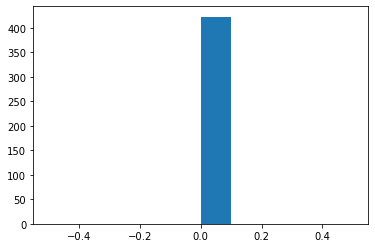

In [146]:
plt.hist(eval_metrics['precision'])

(array([  0.,   0.,   0.,   0.,   0., 423.,   0.,   0.,   0.,   0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <BarContainer object of 10 artists>)

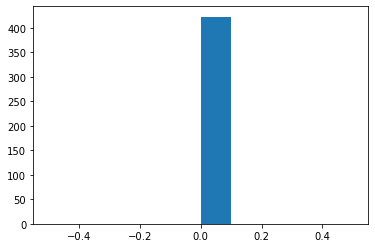

In [147]:
plt.hist(eval_metrics['recall'])

In [148]:
print(classification_report(
    y_expected,
    y_pred, output_dict=False))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.00      0.00      0.00        40
           2       0.00      0.00      0.00       250
           3       0.00      0.00      0.00       110
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        20
           6       0.01      0.01      0.01       350
           7       0.00      0.00      0.00       120
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00       570
          10       0.00      0.00      0.00       370
          11       0.00      0.00      0.00        20
          12       0.02      0.06      0.03      1040
          13       0.02      0.03      0.02      1000
          14       0.05      0.02      0.03      1830
          15       0.00      0.00      0.00       310
          16       0.03      0.01      0.01       300
          17       0.00    

/home/vkanoria/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vkanoria/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Plot metrics for most popular genres

In [169]:
counter=collections.Counter(genres_list)
most_popular_genres_list = [value for value, count in counter.most_common(15)]
eval_metrics_pop = pd.DataFrame()
eval_metrics_pop.loc[:,'genre'] = most_popular_genres_list
eval_metrics_pop.loc[:,'precision']=''
eval_metrics_pop.loc[:,'recall']=''
eval_metrics_pop.loc[:,'f1score']=''
precision_list = []
for j in range(len(most_popular_genres_list)):
    genre = most_popular_genres_list[j]
    i = unique_genres_list.index(genre)
    eval_metrics_pop.iloc[j,1] = precision_score(y_expected[:,i], y_pred[:,i])
    eval_metrics_pop.iloc[j,2] = recall_score(y_expected[:,i], y_pred[:,i])
    eval_metrics_pop.iloc[j,3]= f1_score(y_expected[:,i], y_pred[:,i])
    

In [170]:
eval_metrics_pop.to_csv('eval_metrics_pop_paragraph_smalldataset.csv')

In [171]:
eval_metrics_pop

,genre,precision,recall,f1score
0,Fiction,0.690531,0.585079,0.633446
1,Fantasy,0.316928,0.267934,0.290379
2,Romance,0.245065,0.292186,0.266559
3,Young Adult,0.252477,0.305914,0.276639
4,Mystery,0.172282,0.201252,0.185644
5,Historical,0.158554,0.117147,0.134741
6,Paranormal,0.102605,0.068308,0.082016
7,Science Fiction,0.133178,0.153226,0.1425
8,Contemporary,0.150396,0.248986,0.187522
9,Historical Fiction,0.152427,0.114673,0.130882


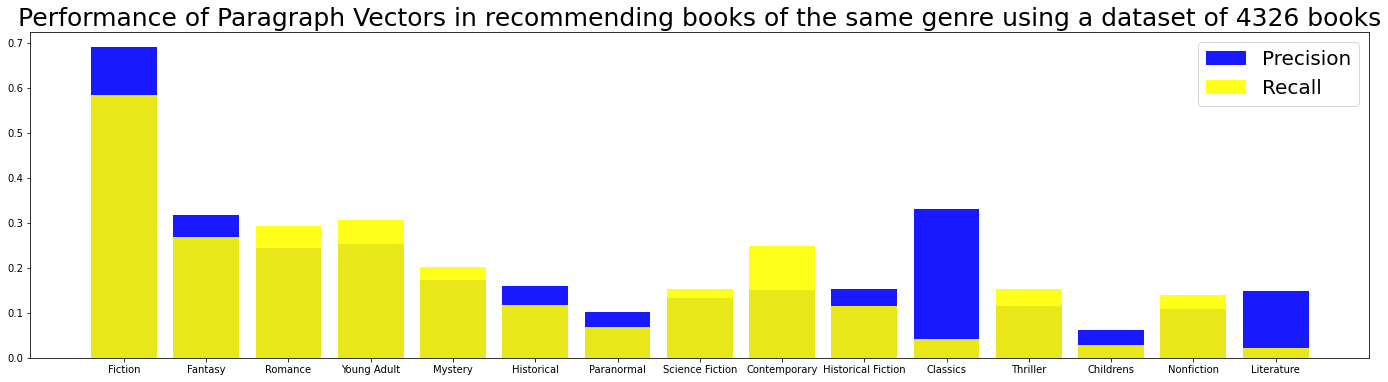

In [172]:
plt.figure(figsize=(24,6))
plt.bar(x=eval_metrics_pop.genre, height = eval_metrics_pop.precision, color = 'blue', alpha=0.9, label='Precision')
plt.bar(x=eval_metrics_pop.genre, height = eval_metrics_pop.recall, color = 'yellow', alpha=0.9, label='Recall')
plt.legend(prop={'size': 20})
plt.title('Performance of Paragraph Vectors in recommending books of the same genre using a dataset of 4326 books', size=25)
#plt.savefig('Paragraph_top_15_small_dataset_bar_chart.png')
plt.show()

## Comparison with random recommender

In [283]:
random_eval_metrics_df = pd.read_csv('eval_metrics_pop_random_smalldataset.csv')
random_eval_metrics_df = random_eval_metrics_df.iloc[:,1:]
random_eval_metrics_df = random_eval_metrics_df.rename(columns = {'precision': 'precision_random',
                                                                  'recall': 'recall_random',
                                                                 'f1score': 'f1score_random'})

eval_metrics_comparison = pd.merge(eval_metrics_pop , random_eval_metrics_df, on = 'genre', how = 'inner')
eval_metrics_comparison =eval_metrics_comparison.rename(columns = {'precision': 'precision_paragraph',
                                                                  'recall': 'recall_paragraph',
                                                                 'f1score': 'f1score_paragraph'})

In [284]:
eval_metrics_comparison

,genre,precision_paragraph,recall_paragraph,f1score_paragraph,precision_random,recall_random,f1score_random
0,Fiction,0.690531,0.585079,0.633446,0.685933,0.689121,0.687523
1,Fantasy,0.316928,0.267934,0.290379,0.327599,0.322382,0.324969
2,Romance,0.245065,0.292186,0.266559,0.253484,0.253767,0.253626
3,Young Adult,0.252477,0.305914,0.276639,0.250223,0.251792,0.251005
4,Mystery,0.172282,0.201252,0.185644,0.163864,0.170793,0.167257
5,Historical,0.158554,0.117147,0.134741,0.160774,0.161457,0.161114
6,Paranormal,0.102605,0.068308,0.082016,0.118312,0.116488,0.117393
7,Science Fiction,0.133178,0.153226,0.1425,0.134622,0.134767,0.134695
8,Contemporary,0.150396,0.248986,0.187522,0.156592,0.151950,0.154236
9,Historical Fiction,0.152427,0.114673,0.130882,0.150854,0.152153,0.151501


### Precision

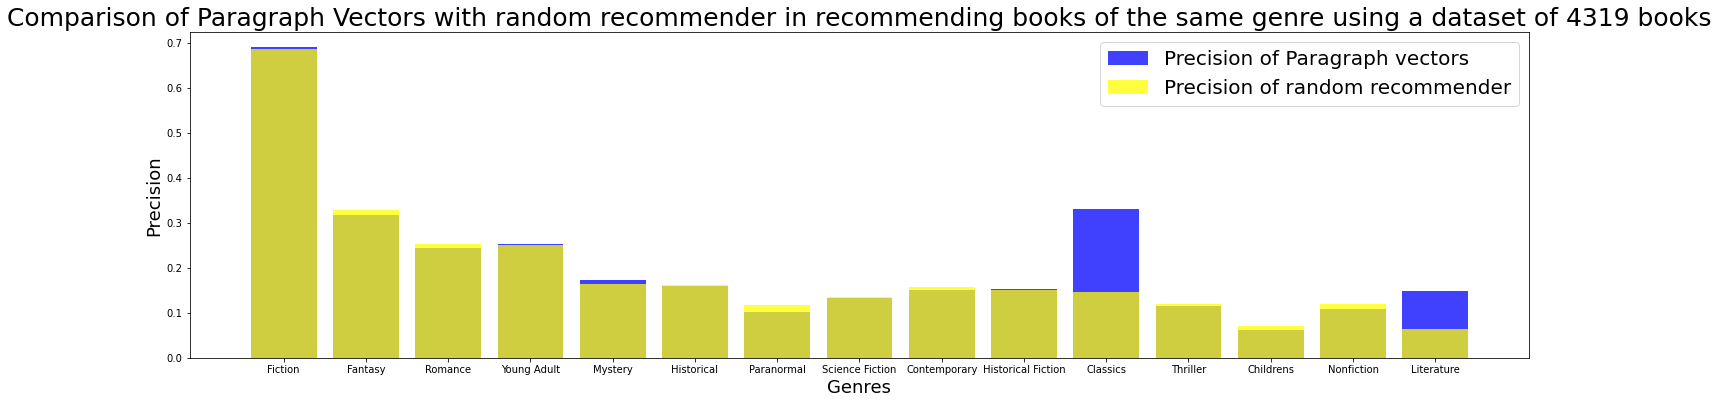

In [285]:
plt.figure(figsize=(24,6))
plt.bar(x=eval_metrics_comparison.genre, height = eval_metrics_comparison.precision_paragraph, color = 'blue', alpha=0.75, label='Precision of Paragraph vectors')
plt.bar(x=eval_metrics_pop.genre, height = eval_metrics_comparison.precision_random, color = 'yellow', alpha=0.75, label='Precision of random recommender')
plt.legend(prop={'size': 20})
plt.xlabel('Genres', size=18)
plt.ylabel('Precision', size=18)
plt.title('Comparison of Paragraph Vectors with random recommender in recommending books of the same genre using a dataset of 4319 books', size=25)
#plt.savefig('Avgword2vec_comparison_with_random_small_dataset_bar_chart_precision.png')
plt.show()

### Recall

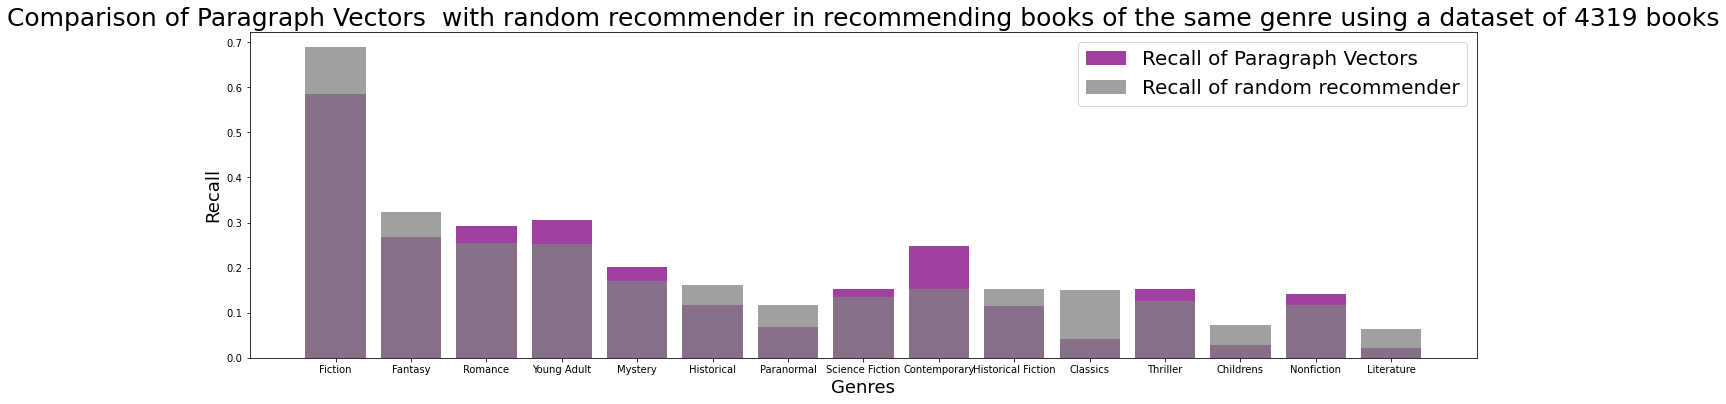

In [286]:
plt.figure(figsize=(22,6))
plt.bar(x=eval_metrics_comparison.genre, height = eval_metrics_comparison.recall_paragraph, color = 'purple', alpha=0.75, label='Recall of Paragraph Vectors')
plt.bar(x=eval_metrics_pop.genre, height = eval_metrics_comparison.recall_random, color = 'grey', alpha=0.75, label='Recall of random recommender')
plt.legend(prop={'size': 20})
plt.xlabel('Genres', size=18)
plt.ylabel('Recall', size=18)
plt.title('Comparison of Paragraph Vectors  with random recommender in recommending books of the same genre using a dataset of 4319 books', size=25)
#plt.savefig('Paragraph_comparison_with_random_small_dataset_bar_chart_recall.png')
plt.show()

### Add Average Word2Vec, Bert and TF-IDF to the comparison

In [287]:
avg_word2vec_eval_metrics = pd.read_csv('eval_metrics_pop_avg_word2vec_smalldataset.csv')

In [288]:
avg_word2vec_eval_metrics = avg_word2vec_eval_metrics.iloc[:,1:]

In [289]:
avg_word2vec_eval_metrics  = avg_word2vec_eval_metrics.rename(columns = {'precision': 'precision_avgword2vec',
                                                                  'recall': 'recall_avgword2vec',
                                                                 'f1score': 'f1score_avgword2vec'})

In [290]:
eval_metrics_comparison = pd.merge(eval_metrics_comparison , avg_word2vec_eval_metrics , on = 'genre', how = 'inner')

In [291]:
eval_metrics_pop_bert = pd.read_csv('eval_metrics_pop_bert_smalldataset.csv').iloc[:,1:]
eval_metrics_pop_bert = eval_metrics_pop_bert.rename(columns = {'precision': 'precision_bert',
                                                                  'recall': 'recall_bert',
                                                                 'f1score': 'f1score_bert'})

In [292]:
eval_metrics_comparison = pd.merge(eval_metrics_comparison , eval_metrics_pop_bert , on = 'genre', how = 'inner')

In [293]:
eval_metrics_pop_tfidf = pd.read_csv('eval_metrics_pop_tfidf_smalldataset.csv').iloc[:,1:]
eval_metrics_pop_tfidf = eval_metrics_pop_tfidf.rename(columns = {'precision': 'precision_tfidf',
                                                                  'recall': 'recall_tfidf',
                                                                 'f1score': 'f1score_tfidf'})

In [294]:
eval_metrics_pop_tfidf

,genre,precision_tfidf,recall_tfidf,f1score_tfidf
0,Fiction,0.798479,0.756686,0.777021
1,Fantasy,0.593627,0.604017,0.598777
2,Romance,0.561997,0.584372,0.572966
3,Young Adult,0.578373,0.484050,0.527024
4,Mystery,0.528270,0.431433,0.474966
5,Historical,0.357655,0.409105,0.381653
6,Paranormal,0.513730,0.520771,0.517227
7,Science Fiction,0.431107,0.365591,0.395656
8,Contemporary,0.361905,0.355694,0.358773
9,Historical Fiction,0.353269,0.384370,0.368164


In [295]:
eval_metrics_comparison = pd.merge(eval_metrics_comparison , eval_metrics_pop_tfidf , on = 'genre', how = 'inner')

In [296]:
eval_metrics_comparison

,genre,precision_paragraph,recall_paragraph,f1score_paragraph,precision_random,recall_random,f1score_random,precision_avg_word2vec,recall_avg_word2vec,f1score_avg_word2vec,precision_bert,recall_bert,f1score_bert,precision_tfidf,recall_tfidf,f1score_tfidf
0,Fiction,0.690531,0.585079,0.633446,0.685933,0.689121,0.687523,0.719324,0.667767,0.692587,0.757723,0.764852,0.761271,0.798479,0.756686,0.777021
1,Fantasy,0.316928,0.267934,0.290379,0.327599,0.322382,0.324969,0.317116,0.285222,0.300325,0.441342,0.521571,0.478114,0.593627,0.604017,0.598777
2,Romance,0.245065,0.292186,0.266559,0.253484,0.253767,0.253626,0.306183,0.383256,0.340411,0.413592,0.492322,0.449536,0.561997,0.584372,0.572966
3,Young Adult,0.252477,0.305914,0.276639,0.250223,0.251792,0.251005,0.295479,0.343190,0.317552,0.417461,0.477301,0.445380,0.578373,0.484050,0.527024
4,Mystery,0.172282,0.201252,0.185644,0.163864,0.170793,0.167257,0.162043,0.133241,0.146237,0.291819,0.321528,0.305954,0.528270,0.431433,0.474966
5,Historical,0.158554,0.117147,0.134741,0.160774,0.161457,0.161114,0.147368,0.123217,0.134215,0.252124,0.287727,0.268752,0.357655,0.409105,0.381653
6,Paranormal,0.102605,0.068308,0.082016,0.118312,0.116488,0.117393,0.145199,0.106210,0.122681,0.242594,0.316309,0.274590,0.513730,0.520771,0.517227
7,Science Fiction,0.133178,0.153226,0.1425,0.134622,0.134767,0.134695,0.132414,0.113620,0.122299,0.223248,0.219395,0.221305,0.431107,0.365591,0.395656
8,Contemporary,0.150396,0.248986,0.187522,0.156592,0.151950,0.154236,0.179408,0.327301,0.231772,0.295827,0.316404,0.305769,0.361905,0.355694,0.358773
9,Historical Fiction,0.152427,0.114673,0.130882,0.150854,0.152153,0.151501,0.142273,0.122169,0.131457,0.238764,0.274121,0.255224,0.353269,0.384370,0.368164


### Precision

3 Methods

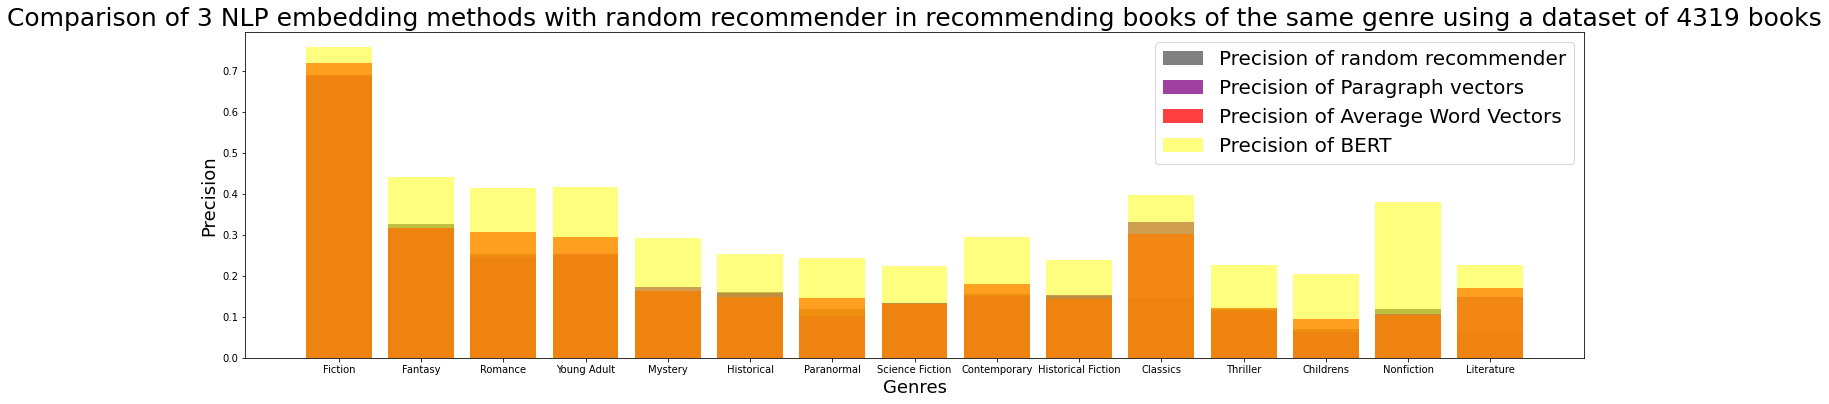

In [203]:
plt.figure(figsize=(24,6))
plt.bar(x=eval_metrics_pop.genre, height = eval_metrics_comparison.precision_random, color = 'grey', label='Precision of random recommender')
plt.bar(x=eval_metrics_comparison.genre, height = eval_metrics_comparison.precision_paragraph, color = 'purple', alpha=0.75, label='Precision of Paragraph vectors')
plt.bar(x=eval_metrics_pop.genre, height = eval_metrics_comparison.precision_avgword2vec, color = 'red', alpha=0.75, label='Precision of Average Word Vectors')
plt.bar(x=eval_metrics_pop.genre, height = eval_metrics_comparison.precision_bert, color = 'yellow', alpha=0.5, label='Precision of BERT')
plt.legend(prop={'size': 20})
plt.xlabel('Genres', size=18)
plt.ylabel('Precision', size=18)
plt.title('Comparison of 3 NLP embedding methods with random recommender in recommending books of the same genre using a dataset of 4319 books', size=25)
#plt.savefig('Avgword2vec_comparison_with_random_small_dataset_bar_chart_precision.png')
plt.show()

### Recall

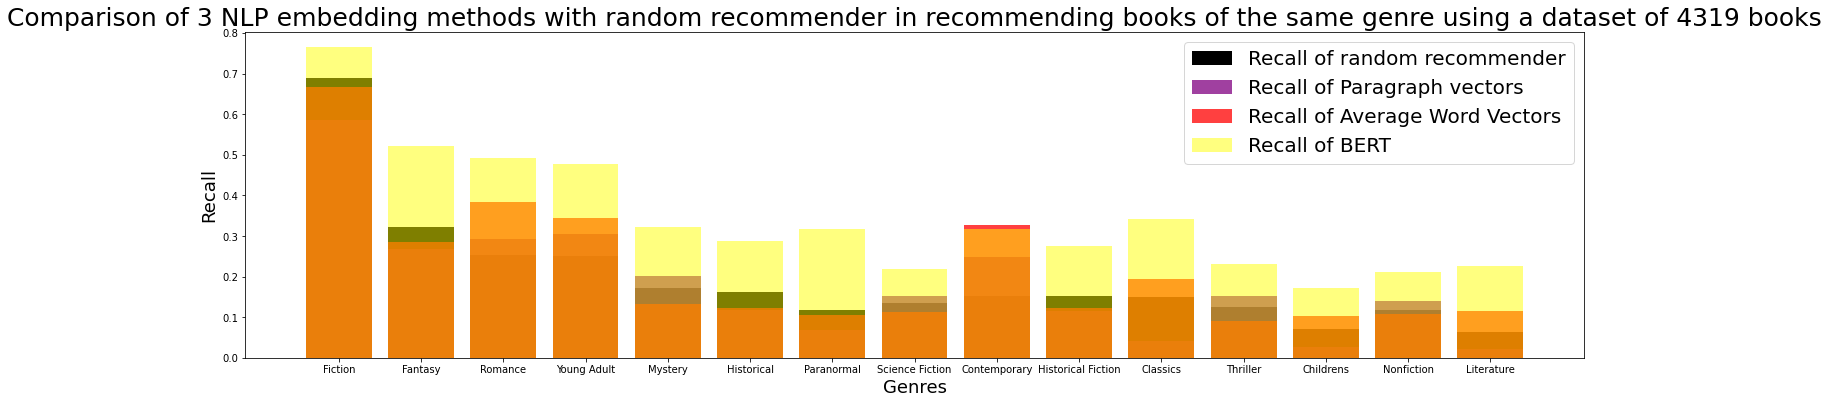

In [206]:
plt.figure(figsize=(24,6))
plt.bar(x=eval_metrics_pop.genre, height = eval_metrics_comparison.recall_random, color = 'black', label='Recall of random recommender')
plt.bar(x=eval_metrics_comparison.genre, height = eval_metrics_comparison.recall_paragraph, color = 'purple', alpha=0.75, label='Recall of Paragraph vectors')
plt.bar(x=eval_metrics_pop.genre, height = eval_metrics_comparison.recall_avgword2vec, color = 'red', alpha=0.75, label='Recall of Average Word Vectors')
plt.bar(x=eval_metrics_pop.genre, height = eval_metrics_comparison.recall_bert, color = 'yellow', alpha=0.5, label='Recall of BERT')
plt.legend(prop={'size': 20})
plt.xlabel('Genres', size=18)
plt.ylabel('Recall', size=18)
plt.title('Comparison of 3 NLP embedding methods with random recommender in recommending books of the same genre using a dataset of 4319 books', size=25)
#plt.savefig('Paragraph_comparison_with_random_small_dataset_bar_chart_recall.png')
plt.show()

## Side by side bar plot: Precision:

In [302]:
#3 Methods
precision_df = eval_metrics_comparison.iloc[0:15,[0, 4,1,7,10]]

In [311]:
#4 methods
precision_df2 = eval_metrics_comparison.iloc[0:15,[0,4,13,1,7,10]]

In [312]:
precision_df2

,genre,precision_random,precision_tfidf,precision_paragraph,precision_avg_word2vec,precision_bert
0,Fiction,0.685933,0.798479,0.690531,0.719324,0.757723
1,Fantasy,0.327599,0.593627,0.316928,0.317116,0.441342
2,Romance,0.253484,0.561997,0.245065,0.306183,0.413592
3,Young Adult,0.250223,0.578373,0.252477,0.295479,0.417461
4,Mystery,0.163864,0.528270,0.172282,0.162043,0.291819
5,Historical,0.160774,0.357655,0.158554,0.147368,0.252124
6,Paranormal,0.118312,0.513730,0.102605,0.145199,0.242594
7,Science Fiction,0.134622,0.431107,0.133178,0.132414,0.223248
8,Contemporary,0.156592,0.361905,0.150396,0.179408,0.295827
9,Historical Fiction,0.150854,0.353269,0.152427,0.142273,0.238764


In [316]:
#precision_df = precision_df.set_index('genre')
precision_df2 = precision_df2.set_index('genre')

3 methods

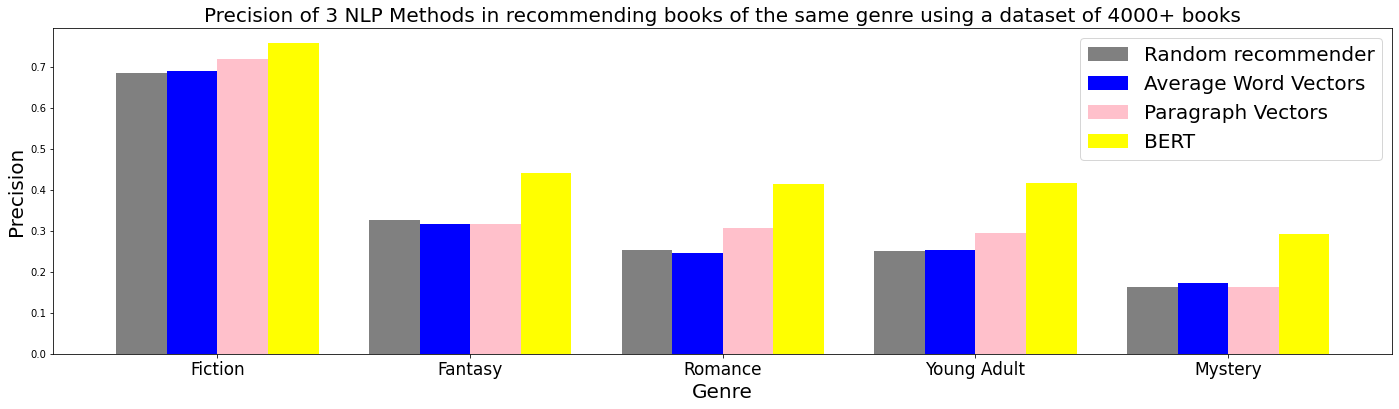

In [299]:
precision_df.plot(kind='bar', rot=0, color = ['grey', 'blue', 'pink','yellow'],width=0.8, figsize=(24, 6))
plt.title("Precision of 3 NLP Methods in recommending books of the same genre using a dataset of 4000+ books", size=20)
plt.xlabel("Genre", size=20)
plt.ylabel("Precision", size=20)
plt.xticks(size=17)
plt.legend(prop={'size': 20}, labels =['Random recommender', 'Average Word Vectors','Paragraph Vectors','BERT'])
plt.savefig('First3_methods_small_dataset_bar_chart_precision_top5.png')
plt.show()

4 methods

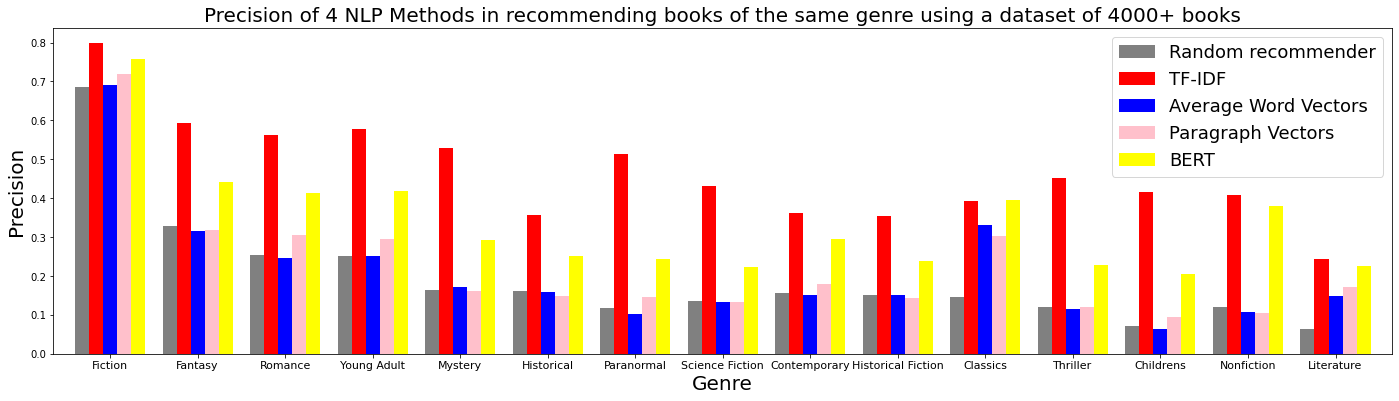

In [321]:
precision_df2.plot(kind='bar', rot=0, color = ['grey','red', 'blue', 'pink','yellow'],width=0.8, figsize=(24, 6))
plt.title("Precision of 4 NLP Methods in recommending books of the same genre using a dataset of 4000+ books", size=20)
plt.xlabel("Genre", size=20)
plt.ylabel("Precision", size=20)
plt.xticks(size=11)
plt.legend(prop={'size': 18}, labels =['Random recommender', 'TF-IDF','Average Word Vectors','Paragraph Vectors','BERT'])
#plt.savefig('All_methods_small_dataset_bar_chart_precision_top5.png')
plt.show()

## Side by side bar plot: Recall:

In [328]:
#3 Methods
recall_df = eval_metrics_comparison.iloc[0:15,[0,5,8,2,11]]
recall_df = recall_df.set_index('genre')
recall_df

,recall_random,recall_avg_word2vec,recall_paragraph,recall_bert
genre,,,,
Fiction,0.689121,0.667767,0.585079,0.764852
Fantasy,0.322382,0.285222,0.267934,0.521571
Romance,0.253767,0.383256,0.292186,0.492322
Young Adult,0.251792,0.343190,0.305914,0.477301
Mystery,0.170793,0.133241,0.201252,0.321528
Historical,0.161457,0.123217,0.117147,0.287727
Paranormal,0.116488,0.106210,0.068308,0.316309
Science Fiction,0.134767,0.113620,0.153226,0.219395
Contemporary,0.151950,0.327301,0.248986,0.316404


In [337]:
#4 Methods
recall_df2 = eval_metrics_comparison.iloc[0:15,[0,5,14,8,2,11]]
recall_df2 = recall_df2.set_index('genre')
recall_df2

,recall_random,recall_tfidf,recall_avg_word2vec,recall_paragraph,recall_bert
genre,,,,,
Fiction,0.689121,0.756686,0.667767,0.585079,0.764852
Fantasy,0.322382,0.604017,0.285222,0.267934,0.521571
Romance,0.253767,0.584372,0.383256,0.292186,0.492322
Young Adult,0.251792,0.484050,0.343190,0.305914,0.477301
Mystery,0.170793,0.431433,0.133241,0.201252,0.321528
Historical,0.161457,0.409105,0.123217,0.117147,0.287727
Paranormal,0.116488,0.520771,0.106210,0.068308,0.316309
Science Fiction,0.134767,0.365591,0.113620,0.153226,0.219395
Contemporary,0.151950,0.355694,0.327301,0.248986,0.316404


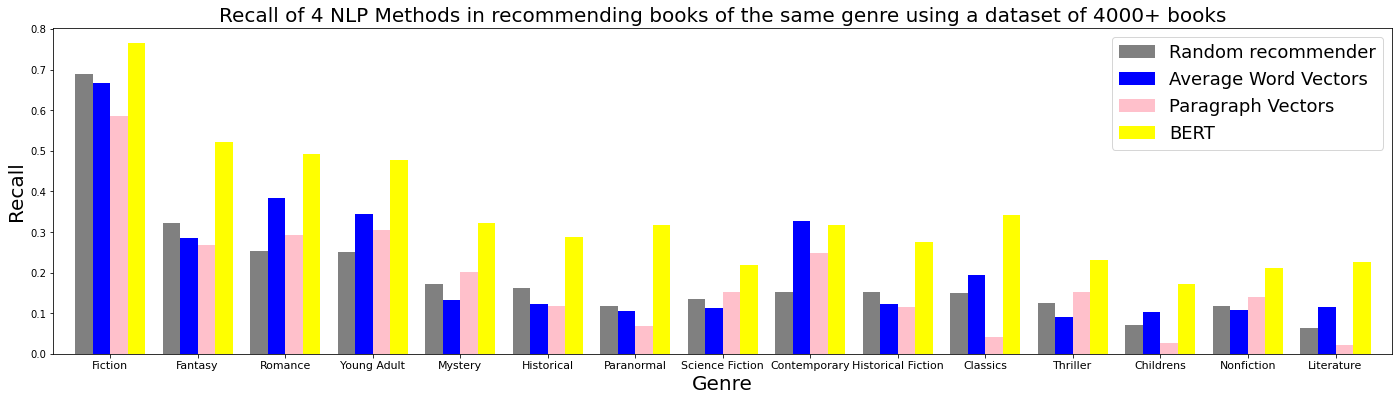

In [335]:
#3 Methods
recall_df.plot(kind='bar', rot=0, color = ['grey', 'blue', 'pink','yellow'],width=0.8, figsize=(24, 6))
plt.title("Recall of 4 NLP Methods in recommending books of the same genre using a dataset of 4000+ books", size=20)
plt.xlabel("Genre", size=20)
plt.ylabel("Recall", size=20)
plt.xticks(size=11)
plt.legend(prop={'size': 18}, labels =['Random recommender', 'Average Word Vectors','Paragraph Vectors','BERT'])
plt.savefig('first3_small_dataset_bar_chart_recall_top5.png')
plt.show()

In [332]:
#4 Methods

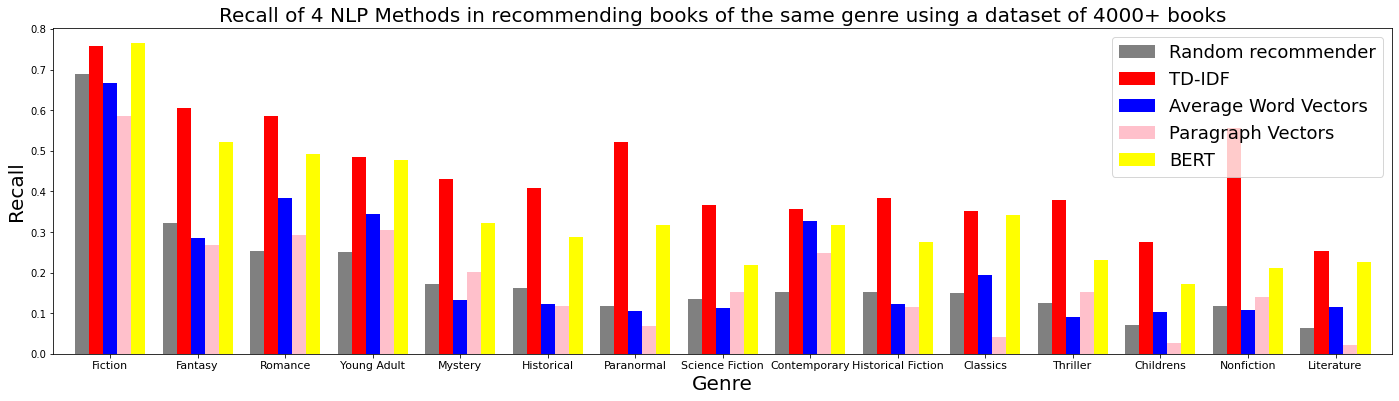

In [338]:

recall_df2.plot(kind='bar', rot=0, color = ['grey', 'red','blue', 'pink','yellow'],width=0.8, figsize=(24, 6))
plt.title("Recall of 4 NLP Methods in recommending books of the same genre using a dataset of 4000+ books", size=20)
plt.xlabel("Genre", size=20)
plt.ylabel("Recall", size=20)
plt.xticks(size=11)
plt.legend(prop={'size': 18}, labels =['Random recommender','TD-IDF', 'Average Word Vectors','Paragraph Vectors','BERT'])
plt.savefig('All_methods_small_dataset_bar_chart_recall_top5.png')
plt.show()